# PROJECT 8
# Twitter US Airline Sentiment
## Aaron Coteff 4.2.2021
### Great Learning AI/ML

## Import and Understand

In [1]:
import pandas as pd
import numpy as np
import unicodedata, re, string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import contractions
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
!python -m spacy download en_core_web_sm
from nltk import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
pd.set_option('display.max_colwidth', None)
pd.set_option('precision', 2)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/acoteff/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/acoteff/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/acoteff/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     |████████████████████████████████| 13.7 MB 5.6 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
tweets = pd.read_csv('Tweets.csv')

In [3]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.00,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.35,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.68,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.00,Bad Flight,0.7,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.00,Can't Tell,1.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
tweets.shape

(14640, 15)

In [5]:
tweets.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,14640.0,5.69e+17,7.79e+14,5.68e+17,5.69e+17,5.69e+17,5.70e+17,5.70e+17
airline_sentiment_confidence,14640.0,9.00e-01,1.63e-01,3.35e-01,6.92e-01,1.00e+00,1.00e+00,1.00e+00
negativereason_confidence,10522.0,6.38e-01,3.30e-01,0.00e+00,3.61e-01,6.71e-01,1.00e+00,1.00e+00
retweet_count,14640.0,8.27e-02,7.46e-01,0.00e+00,0.00e+00,0.00e+00,0.00e+00,4.40e+01


In [6]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [7]:
tweets.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [8]:
tweets = tweets[['airline_sentiment', 'text']]

In [9]:
tweets.shape

(14640, 2)

In [10]:
tweets.head(5)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


## Pre-Process

In [11]:
stopword_list = nltk.corpus.stopwords.words('english')
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words
lemmatizer = WordNetLemmatizer()

In [12]:
    #HTML REMOVAL
def strip_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    stripped_text = soup.get_text()
    return stripped_text

    #HYPERLINK REMOVAL
def strip_links(text):
    text = re.sub(r'http\S+', '', text)
    return text
    
    #HASHTAG & @USER REMOVAL
def strip_hashats(text):
    text = re.sub(r'(@|#)\S+', '', text)
    return text
    
    #NUMBER REMOVAL
def strip_numbers(text):
    cleaned =  re.sub('[0-9]+', '', text)
    return cleaned
    
    #SPECIAL CHARACTER REMOVAL
def strip_non_ascii(text):
    new_word = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_word

    #LEMMATIZATION
def lemmatize(text):
    lemmas = lemmatizer.lemmatize(text, pos = 'v')
    return lemmas

    #CONTRACTION REMOVAL
def strip_contractions(text):
    expansions = contractions.fix(text)
    return expansions

    #LOWERCASE & PUNCTUATION REMOVAL
def to_lowercase_no_puncuation(text):
    new_word = text.lower()
    new_words = re.sub(r'[^\w\s]','', new_word)
    return new_words
    
    #TOKENIZATION
    #STOPWORD REMOVAL
    #CONVERSION BACK TO TEXT STRING
def tokenize_remove_sw_detokenize(text):
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
    untokens = TreebankWordDetokenizer().detokenize(tokens_without_sw)
    return untokens

    #PRE-PROCESS TEXT CLEANING FUNCTION
def pre_processed_text(text):
    text = strip_html(text)
    text = strip_links(text)
    text = strip_hashats(text)
    text = strip_non_ascii(text)
    text = strip_numbers(text)
    text = lemmatize(text)
    text = strip_contractions(text)
    text = to_lowercase_no_puncuation(text)
    text = tokenize_remove_sw_detokenize(text)
    return text

In [13]:
    #RAW TWEETS & SENTIMENTS
tweets.head(5)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [14]:
for i, row in tweets.iterrows():
    clean_text = pre_processed_text(tweets.at[i, 'text'])
    tweets.at[i,'text'] = clean_text

In [15]:
    #CLEANED TWEETS & SENTIMENTS
tweets.head(5)

,airline_sentiment,text
0,neutral,said
1,positive,plus added commercials experience tacky
2,neutral,today mean need trip
3,negative,aggressive blast obnoxious entertainment guests faces little recourse
4,negative,big bad thing


## Vectorize

In [16]:
    #TRANSFORM SENTIMENT INTO INTEGERS
label_dict = {
    'negative' : -1,
    'neutral' : 0,
    'positive' : 1
}

tweets.airline_sentiment = tweets.airline_sentiment.replace(label_dict)
tweets.airline_sentiment.astype('int')
tweets.head()

,airline_sentiment,text
0,0,said
1,1,plus added commercials experience tacky
2,0,today mean need trip
3,-1,aggressive blast obnoxious entertainment guests faces little recourse
4,-1,big bad thing


## COUNT VECTORIZATION

In [17]:
cv = CountVectorizer(max_features = 10798)
cvector = cv.fit_transform(tweets.text)

In [18]:
print(cv.vocabulary_)

{'said': 8221, 'plus': 7120, 'added': 127, 'commercials': 1857, 'experience': 3338, 'tacky': 9329, 'today': 9629, 'mean': 5829, 'need': 6276, 'trip': 9804, 'aggressive': 220, 'blast': 1024, 'obnoxious': 6486, 'entertainment': 3152, 'guests': 4179, 'faces': 3396, 'little': 5503, 'recourse': 7689, 'big': 967, 'bad': 771, 'thing': 9501, 'seriously': 8459, 'pay': 6875, 'flight': 3623, 'seats': 8380, 'playing': 7087, 'flying': 3724, 'va': 10160, 'yes': 10736, 'nearly': 6272, 'time': 9582, 'fly': 3717, 'vx': 10301, 'ear': 2967, 'worm': 10624, 'away': 726, 'missed': 6038, 'prime': 7322, 'opportunity': 6615, 'men': 5883, 'hats': 4285, 'parody': 6817, 'notbut': 6411, 'amazing': 357, 'arrived': 557, 'hour': 4526, 'early': 2971, 'good': 4063, 'know': 5211, 'suicide': 9182, 'second': 8385, 'leading': 5354, 'death': 2412, 'teens': 9414, 'pretty': 7302, 'graphics': 4107, 'better': 942, 'minimal': 5989, 'iconography': 4619, 'great': 4113, 'deal': 2404, 'thinking': 9508, 'nd': 6267, 'gone': 4060, 'st'

In [19]:
cvector = cvector.toarray()
cvector.shape

(14640, 10798)

## TFIDF VECTORIZATION

In [20]:
tfidf = TfidfVectorizer(max_features = 10798)
tfidf.fit(tweets.text)

TfidfVectorizer(max_features=10798)

In [21]:
print(tfidf.vocabulary_)

{'said': 8221, 'plus': 7120, 'added': 127, 'commercials': 1857, 'experience': 3338, 'tacky': 9329, 'today': 9629, 'mean': 5829, 'need': 6276, 'trip': 9804, 'aggressive': 220, 'blast': 1024, 'obnoxious': 6486, 'entertainment': 3152, 'guests': 4179, 'faces': 3396, 'little': 5503, 'recourse': 7689, 'big': 967, 'bad': 771, 'thing': 9501, 'seriously': 8459, 'pay': 6875, 'flight': 3623, 'seats': 8380, 'playing': 7087, 'flying': 3724, 'va': 10160, 'yes': 10736, 'nearly': 6272, 'time': 9582, 'fly': 3717, 'vx': 10301, 'ear': 2967, 'worm': 10624, 'away': 726, 'missed': 6038, 'prime': 7322, 'opportunity': 6615, 'men': 5883, 'hats': 4285, 'parody': 6817, 'notbut': 6411, 'amazing': 357, 'arrived': 557, 'hour': 4526, 'early': 2971, 'good': 4063, 'know': 5211, 'suicide': 9182, 'second': 8385, 'leading': 5354, 'death': 2412, 'teens': 9414, 'pretty': 7302, 'graphics': 4107, 'better': 942, 'minimal': 5989, 'iconography': 4619, 'great': 4113, 'deal': 2404, 'thinking': 9508, 'nd': 6267, 'gone': 4060, 'st'

In [22]:
print(tfidf.idf_)

[9.89843391 5.11931042 9.89843391 ... 9.89843391 9.20528673 9.89843391]


In [23]:
tfidfv = tfidf.transform(tweets.text)

In [24]:
tfidfv = tfidfv.toarray()
tfidfv.shape

(14640, 10798)

## COUNT VECTORIZER MODEL

In [25]:
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(cvector, tweets.airline_sentiment, test_size = .3, random_state = 42)


In [26]:
C_forest = RandomForestClassifier(n_estimators=10)
C_forest = C_forest.fit(X_train_C, y_train_C)
print(C_forest)
print()
print('Cross Validation Score:')
print(np.mean(cross_val_score(C_forest, cvector, tweets.airline_sentiment, cv = 10)))

RandomForestClassifier(n_estimators=10)

Cross Validation Score:
0.7200136612021858


In [27]:
cvector_results = C_forest.predict(X_test_C)

In [28]:
conf_mat_C = confusion_matrix(y_test_C, cvector_results)
print(conf_mat_C)

[[2373  319  122]
 [ 335  454   95]
 [ 174   89  431]]


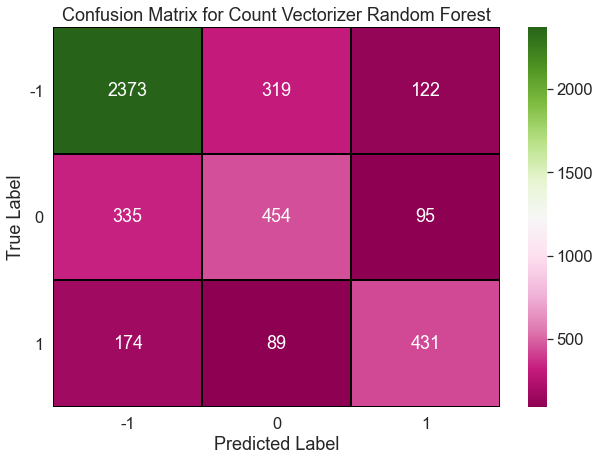

In [40]:
df_cm = pd.DataFrame(conf_mat_C, index = [[-1, 0, 1]], columns = [[-1, 0, 1]])
plt.figure(figsize = (10,7))
sns.set(font_scale = 1.5)
sns.heatmap(df_cm, annot = True, fmt = 'g', cmap = 'PiYG', linewidths = 1, linecolor = 'black')
plt.title('Confusion Matrix for Count Vectorizer Random Forest')
plt.yticks(rotation = 0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label');

In [30]:
print('Count Vectorizer Accuracy Score:')
accuracy_score(y_test_C, cvector_results)

Count Vectorizer Accuracy Score:


0.7418032786885246

## TFIDF VECTORIZER MODEL

In [31]:
X_train_I, X_test_I, y_train_I, y_test_I = train_test_split(tfidfv, tweets.airline_sentiment, test_size = .3, random_state = 42)


In [32]:
I_forest = RandomForestClassifier(n_estimators=10)
I_forest = I_forest.fit(X_train_I, y_train_I)
print(I_forest)
print()
print('Cross Validation Score:')
print(np.mean(cross_val_score(I_forest, tfidfv, tweets.airline_sentiment, cv = 10)))

RandomForestClassifier(n_estimators=10)

Cross Validation Score:
0.7265027322404372


In [33]:
ivector_results = I_forest.predict(X_test_I)

In [34]:
conf_mat_I = confusion_matrix(y_test_I, ivector_results)
print(conf_mat_I)

[[2516  221   77]
 [ 412  394   78]
 [ 233   89  372]]


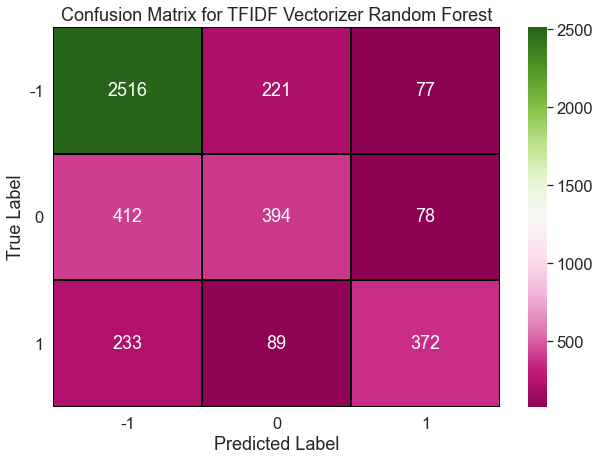

In [39]:
df_cm = pd.DataFrame(conf_mat_I, index = [[-1, 0, 1]], columns = [[-1, 0, 1]])
plt.figure(figsize = (10,7))
sns.set(font_scale = 1.5)
sns.heatmap(df_cm, annot = True, fmt = 'g', cmap = 'PiYG', linewidths = 1, linecolor = 'black')
plt.title('Confusion Matrix for TFIDF Vectorizer Random Forest')
plt.yticks(rotation = 0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label');

In [36]:
print('TFIDF Vectorizer Accuracy Score:')
accuracy_score(y_test_I, ivector_results)

TFIDF Vectorizer Accuracy Score:


0.7472677595628415

## Model Metrics

In [37]:
print('Count Vector Metrics:')
print(classification_report(y_test_C, cvector_results))

Count Vector Metrics:
              precision    recall  f1-score   support

          -1       0.82      0.84      0.83      2814
           0       0.53      0.51      0.52       884
           1       0.67      0.62      0.64       694

    accuracy                           0.74      4392
   macro avg       0.67      0.66      0.67      4392
weighted avg       0.74      0.74      0.74      4392



In [38]:
print('TFIDF Vector Metrics:')
print(classification_report(y_test_I, ivector_results))

TFIDF Vector Metrics:
              precision    recall  f1-score   support

          -1       0.80      0.89      0.84      2814
           0       0.56      0.45      0.50       884
           1       0.71      0.54      0.61       694

    accuracy                           0.75      4392
   macro avg       0.69      0.63      0.65      4392
weighted avg       0.73      0.75      0.74      4392



## SUMMARIZATION

### Pre_Processing

#### By pre-processing, we are able to concentrate the essential sentiments of the tweets, highlighting the more important words by eliminating those which add relatively little value to the overall understanding of each tweet. I decided to push that even further by removing hashtags, hyperlinks, and @user handles. By doing this I was able to rely less on vague, obscure abstractions and push forward the words that provide more concrete, universal understanding. We also see that by eliminating numbers, punctuation, and special characters, we shape the structure of each tweet into a more poignant abstraction. By stripping them down and removing a certain contextual sense of meaning, we allow the underlying 'nuts and bolts' of the ideas shine forth. The conversion to lowercase levels the playing field even further, leaving no word with more thrust than any other; each speaking its truth upon its own merit. The process of lemmatization also follows this trend of concentrated abstraction, and allows us to reshape each word down to its native meaning. I wrestled with not being able to convert the emojis present into concrete sentiments, and eventually let go of that in order to concentrate on the written words.

### Vectorization

#### Having woven this fabric of words, we must make sure that it is the right fit for the model. Much like how a designer may tailor clothing for a specific individual, or may mass produce an article for a wider audience, we see minor differences in our approaches to vectorization. The count vectorization gives us a very broad sense, and checks a box for each word, giving us a bag that most will find acceptable and that fits fairly well. With term frequency x inverse document frequency we see more of workings of haute couture, where the individual word is given a unique value that defines it apart from the rest of the words. We see how each stands out apart from the rest showing itself as not merely a number to be counted, but having a certain refinement in and of itself. We shall see how this distinction appears in how each of these fit the model.

### The Models

#### The TFIDF model seems to be the best fit, by only by a very slight margin. Both models do not seem to be overfit, and both perform quite well. Each has a harder time identifying the neutral sentiments, and by far each is able to best identify the negative sentiments. This is no surprise since our data is taken from Twitter, where the general vibe overall leans towards a certain critical thinking, and not in the traditional educational sense. We see the Count Vectorizer model perform better with regards the neutral sentiments as well as having a better F1 score across the board than the TFIDF Vectorizer.  It is difficult to say which one is better in the end, as both models are cut from the same fabric of words, and differ only by virtue of their vectorizers. In my opinion the TFIDF model shines just a bit brighter of the two, and I gravitate towards the refined approach that it takes compared to Count Vectorizer. 

#### It's been a pleasure learning!! Thank you!